In [311]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Dutch parliament as an Ising ferromagnet

## Importing and processing

Data van tweede kamer verkiezingen na 2008:

- 9 juni 2010
- 12 september 2012
- 15 maart 2017
- 17 maart 2021
- 22 november 2023

Zoek opdracht voor moties over een bepaalde periode:

In [231]:
# Periode kabinet Rutte III
search_query = "?$filter=Verwijderd eq false and Vergissing eq false and ((year(GewijzigdOp) eq 2012 and month(GewijzigdOp) ge 10) or (year(GewijzigdOp) ge 2013 and year(GewijzigdOp) le 2016) or (year(GewijzigdOp) eq 2017 and month(GewijzigdOp) le 2)) & orderby=GewijzigdOp"

In [234]:
url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Stemming{search_query}"
response = requests.get(url)
data = response.json()
data; 

Moties tijdens kabinet Rutte III:

In [233]:
# Define the initial URL
url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Stemming{search_query}"

# Initialize an empty list to store all the data points
all_data = []

# Loop to fetch all pages of data
while url:
    # Make an HTTP GET request to the current URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Convert the JSON response to a Python dictionary
        data = response.json()
        
        # Extract the 'value' part of the JSON response and append it to the list
        all_data.extend(data['value'])
        
        # Check if there's a next page link
        if '@odata.nextLink' in data:
            # Update the URL to fetch the next page of data
            url = data['@odata.nextLink']
        else:
            # If there's no next page link, exit the loop
            url = None
    else:
        # If the request was not successful, print an error message and exit the loop
        print("Error:", response.status_code)
        url = None

# Convert the list of data points to a Pandas DataFrame
df = pd.DataFrame(all_data).sort_values(by='GewijzigdOp')

# Raw data array containing most motions during Rutte III. 
df


Hoeveel moties waren er?

In [280]:
df['Besluit_Id'].nunique()

636

Partijen:

In [404]:
parties = df['ActorFractie'].unique()
parties

array(['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PvdA',
       'PvdD', 'PVV', 'SGP', 'SP', 'VVD', 'Bontes', 'Van Vliet',
       'Van Klaveren', 'GrBvK', '50PLUS/Baay-Timmerman', '50PLUS/Klein',
       'Klein', 'GrKÖ', 'Houwers', 'Monasch'], dtype=object)

We negeren de ondestaande afgesplinterde partijen (in haakjes hun originele partij):
- Bontes (PVV)
- Van Vliet (PVV) (sloot zich niet aan bij de tweede kamer fractie van de VVD in 2018)
- Klein (50Plus)
- Houwers (VVD)
- 50PLUS/Klein (50Plus)
- 50PLUS/Baay-Timmerman (50Plus)
- Van Klaveren (PVV)
- GrBvK (PVV)
- GrKÖ (PvdA)

Ik haal ook 50PLUS eruit want die partij viel uit elkaar.


In [517]:
# Parties to ignore
#ignore_parties = ['Klein', 'GrKÖ', 'Van Vliet', '50PLUS', '50PLUS/Klein', 'Houwers', 'Van Klaveren', 'GrBvK', 'Bontes', '50PLUS/Baay-Timmerman', 'Monasch']
# Create a boolean mask to mark the elements you want to keep
#mask = np.isin(parties, ignore_parties, invert=True)
# Filter out the elements you want to keep
#filtered_parties = parties[mask]

#filtered_parties = np.array(['SP', 'GroenLinks', 'PvdA', 'PvdD', 'ChristenUnie', 'D66', 'CDA', 'VVD','PVV','SGP'])
filtered_parties = np.array(['PVV', 'PvdD', 'SP', 'GroenLinks', 'D66', 'ChristenUnie', 'SGP', 'CDA', 'PvdA','VVD'])



#filtered_parties_short = np.array(['SP', 'GL', 'PvdA', 'PvdD', 'CU', 'D66', 'CDA', 'VVD','PVV','SGP'])
filtered_parties_short = np.array(['PVV','PvdD','SP', 'GL', 'D66', 'CU', 'SGP', 'CDA', 'PvdA','VVD'])

Process the dataframe:

In [518]:
# Remove ignored parties
processed_df = df[df['ActorFractie'].isin(filtered_parties)]

# Only keep cases where ActorNaam == ActorFractie, i.e. vote cast as a party
processed_df = processed_df[processed_df['ActorNaam'] == processed_df['ActorFractie']]

# Keep only relevant columns 
processed_df = processed_df[['Besluit_Id','Soort', 'ActorFractie']]

# Replace votes with numerical values
processed_df['Soort'] = processed_df['Soort'].map({'Voor': 1, 'Tegen': -1, 'Niet deelgenomen':0})
processed_df = processed_df.reset_index(drop=True)

processed_df

,Besluit_Id,Soort,ActorFractie
0,57e214d1-785a-4094-b9c9-348c6d587464,1,CDA
1,57e214d1-785a-4094-b9c9-348c6d587464,1,ChristenUnie
2,57e214d1-785a-4094-b9c9-348c6d587464,1,D66
3,57e214d1-785a-4094-b9c9-348c6d587464,1,GroenLinks
4,57e214d1-785a-4094-b9c9-348c6d587464,1,PvdA
...,...,...,...
6255,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,PvdA
6256,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,SGP
6257,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,PvdD
6258,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,PVV


## Asymmetric dataset

In [519]:
pivot_df = processed_df.pivot(index='Besluit_Id', columns='ActorFractie', values='Soort').fillna(0)
pivot_df = pivot_df[filtered_parties] # sorting columns
pivot_df

ActorFractie,PVV,PvdD,SP,GroenLinks,D66,ChristenUnie,SGP,CDA,PvdA,VVD
Besluit_Id,,,,,,,,,,
0001864e-d3c6-4624-a93f-a0f8dd4c04cc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
011086ac-713f-455c-bd37-22591ad5ceb4,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01eb5f6c-1a76-4c13-bdb1-c8d7eb9e6ca7,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02257872-4505-4fcc-b545-6ae5f15efefd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02435d6f-a53b-4791-91ce-3f1d098e7f1b,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
fec0ce7a-dfcd-43b0-a1b2-69d8ea1341b6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
fefa9414-00c9-4e33-bb3c-0baeafe18863,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ff078a51-edeb-4146-8580-a212222ed2f4,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Text(0.5, 1.0, 'Tweede kamer moties tijdens Rutte III')

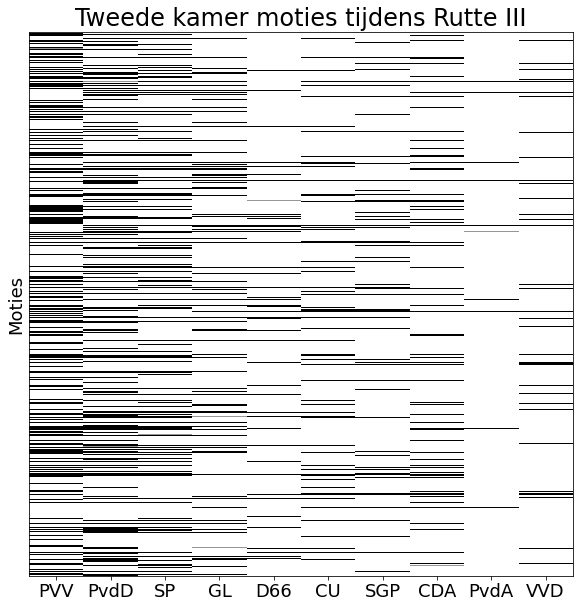

In [520]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(pivot_df, interpolation='none', cmap='Greys_r', extent=[0,10,0,10])
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=18); 
ax.set_yticks([]);
ax.set_ylabel('Moties', fontsize=18)
ax.set_title('Tweede kamer moties tijdens Rutte III', fontsize=24)


Gemiddelde stem per fractie: 

In [521]:
mean_votes = processed_df.groupby('ActorFractie')['Soort'].mean().reset_index()
mean_votes.columns = ['ActorFractie', 'Mean Vote']
mean_votes

,ActorFractie,Mean Vote
0,CDA,0.750799
1,ChristenUnie,0.770335
2,D66,0.824281
3,GroenLinks,0.680000
4,PVV,0.277955
5,PvdA,0.968051
6,PvdD,0.382400
7,SGP,0.789474
8,SP,0.513600
9,VVD,0.881978


In [525]:
correlation_matrix = pivot_df.corr()
correlation_matrix

ActorFractie,PVV,PvdD,SP,GroenLinks,D66,ChristenUnie,SGP,CDA,PvdA,VVD
ActorFractie,,,,,,,,,,
PVV,1.000000,0.226289,0.300301,0.113461,0.022881,-0.000100,0.066679,0.207652,-0.020791,0.079450
PvdD,0.226289,1.000000,0.690908,0.521069,0.290696,0.240943,0.079735,0.174870,0.129568,-0.072586
SP,0.300301,0.690908,1.000000,0.450338,0.294948,0.261819,0.095732,0.257350,0.174325,-0.063623
GroenLinks,0.113461,0.521069,0.450338,1.000000,0.438607,0.257984,0.090298,0.228607,0.268062,0.037668
D66,0.022881,0.290696,0.294948,0.438607,1.000000,0.328862,0.177140,0.162752,0.291779,0.160637
ChristenUnie,-0.000100,0.240943,0.261819,0.257984,0.328862,1.000000,0.544780,0.348081,0.228673,0.143321
SGP,0.066679,0.079735,0.095732,0.090298,0.177140,0.544780,1.000000,0.389159,0.200681,0.266969
CDA,0.207652,0.174870,0.257350,0.228607,0.162752,0.348081,0.389159,1.000000,0.292728,0.273882
PvdA,-0.020791,0.129568,0.174325,0.268062,0.291779,0.228673,0.200681,0.292728,1.000000,0.287287


Correlaties:

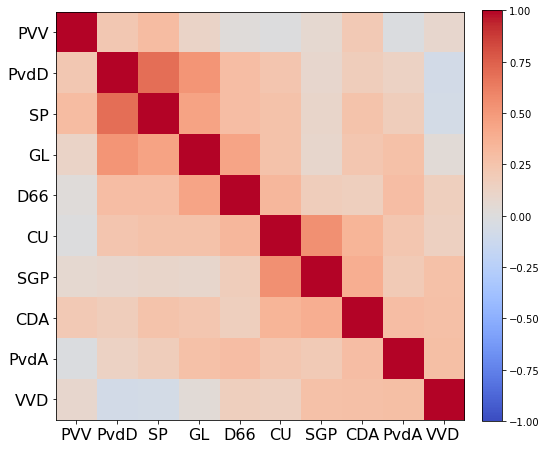

In [526]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=+1, extent=[0,10,0,10])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16); 

## Symmetrised dataset

Maak de dataset symmetrisch. ("Voor" or "Tegen" heeft een arbitraire definitie.)

In [522]:
# Copy the DataFrame and flip the values in the 'Soort' column
sym_df = processed_df.copy()
sym_df['Soort'] = sym_df['Soort'].map({1: -1, -1: 1})

# Add a prefix to the 'Besluit_Id' column in the symmetrized DataFrame
sym_df['Besluit_Id'] = 'sym_' + sym_df['Besluit_Id'].astype(str)

# Concatenate the original DataFrame with the symmetrized one
sym_df = pd.concat([processed_df, sym_df], ignore_index=True)

sym_df

,Besluit_Id,Soort,ActorFractie
0,57e214d1-785a-4094-b9c9-348c6d587464,1,CDA
1,57e214d1-785a-4094-b9c9-348c6d587464,1,ChristenUnie
2,57e214d1-785a-4094-b9c9-348c6d587464,1,D66
3,57e214d1-785a-4094-b9c9-348c6d587464,1,GroenLinks
4,57e214d1-785a-4094-b9c9-348c6d587464,1,PvdA
...,...,...,...
12515,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,PvdA
12516,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,SGP
12517,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,PvdD
12518,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,PVV


In [523]:
sym_pivot_df = sym_df.pivot(index='Besluit_Id', columns='ActorFractie', values='Soort').fillna(0)
sym_pivot_df = sym_pivot_df[filtered_parties] # sorting columns
sym_pivot_df; 

In [524]:
sym_correlation_matrix = sym_pivot_df.corr()
sym_correlation_matrix

ActorFractie,PVV,PvdD,SP,GroenLinks,D66,ChristenUnie,SGP,CDA,PvdA,VVD
ActorFractie,,,,,,,,,,
PVV,1.000000,0.306955,0.390088,0.268585,0.241214,0.213887,0.258579,0.340256,0.263578,0.280926
PvdD,0.306955,1.000000,0.744000,0.612800,0.466827,0.436103,0.346646,0.393285,0.399680,0.305112
SP,0.390088,0.744000,1.000000,0.632000,0.565947,0.538339,0.455272,0.530776,0.533973,0.426518
GroenLinks,0.268585,0.612800,0.632000,1.000000,0.741807,0.643771,0.576678,0.620304,0.706635,0.611822
D66,0.241214,0.466827,0.565947,0.741807,1.000000,0.753392,0.711892,0.678914,0.838658,0.769354
ChristenUnie,0.213887,0.436103,0.538339,0.643771,0.753392,1.000000,0.821372,0.724661,0.782123,0.722488
SGP,0.258579,0.346646,0.455272,0.576678,0.711892,0.821372,1.000000,0.750200,0.794893,0.773525
CDA,0.340256,0.393285,0.530776,0.620304,0.678914,0.724661,0.750200,1.000000,0.774760,0.747007
PvdA,0.263578,0.399680,0.533973,0.706635,0.838658,0.782123,0.794893,0.774760,1.000000,0.887470


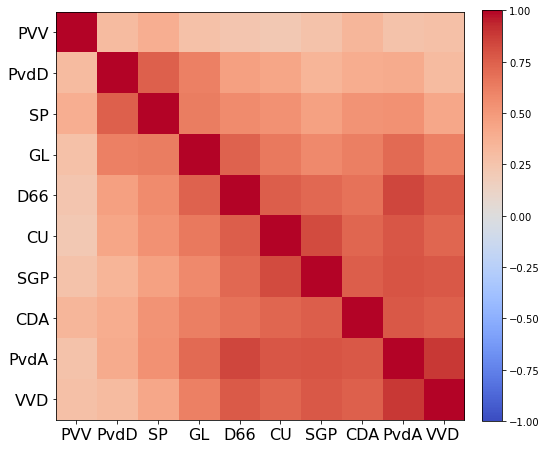

In [528]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(sym_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=+1, extent=[0,10,0,10])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16); 

## Solving the inverse problem